# WIKI-SHEAF

@ Alessio Borgi
@ Stefano Previti

### 0: IMPORTING LIBRARIES

In [255]:
!pip install requests wikipedia-api wptools networkx matplotlib torch torch-geometric sentence-transformers

In [256]:
### LIBRARIES NECESSARY FROM STEP 0 ON ###
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import matplotlib.pyplot as plt

### LIBRARIES NECESSARY FROM STEP 1 ON ###
import json
import pprint
import wptools
import requests
import wikipediaapi
from urllib.parse import urlparse, unquote

### LIBRARIES NECESSARY FROM STEP 2 ON ###
import networkx as nx

### LIBRARIES NECESSARY FROM STEP 3 ON ###
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.data import HeteroData
from torch_geometric.utils import to_networkx
from sentence_transformers import SentenceTransformer



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 0.5: TRAINING SET LOADING, INSPECTION & DISCOVERY

By making some exploration from the dataset, we noticed the following "issues".

**NaN LABEL PRESENCE**

As first thing we noticed that there are 7 rows that are all missing the "label" value.
- We decide to eliminate directly these lines since they are both not useful if they are not providing a label and are only very few outliers (7/6251), due to maybe errors in the labeling step.

**LABEL INCONSISTENCIES**

The list of the labels are not actually really containig only 3 labels. Indeed, by making a set operation over the "labels" column, we noticed that it contains: *{'cultural exclusive', 'cultural', 'cultural agnostic', 'cult', 'cultural representative', 'cultural agn', 'cultural represent', 'cultural ex', 'cultural ag'}*.
  - We decided to counteract this issue by **mantaining only the 3 labels** *{'cultural exclusive', 'cultural representative', 'cultural agnostic'}*.
  - For the lines whose labels are *{'cultural agn', 'cultural ag'}*, the labels are sobstituted with "cultural agnostic".
  - For the lines whose labels are *{'cultural represent'}*, the labels are sobstituted with *{'cultural representative'}*.
  - For the lines whose labels are *{'cultural ex'}*, the labels are sobstituted with *{'cultural exclusive'}*.
  - For the lines whose labels are *{'cultural', 'nan', 'cult'}*, we decided to directly drop them.

(Notice that these labels inconsistencies are really outliers. Indeed, we will remain with out dataset being **6238 samples** long).

**CLASS IMBALANCE**

After this cleaning, we notice that the samples we have at our disposal is not provided in an equal manner, but we have instead a **Class Imbalance** issue, Due to the fact that this is not so imbalanced, we decide to just take this into account at **Training Time**, in the future model, by using a **Class Weighting** in the **Loss Function** (e.g., *Weighted Cross-Entropy*).

#### 0.5.0: SETUP STEP

In [257]:
### SETUP STEP ###

# ADJUST VALUES ACCORDING TO YOUR CASE #

# Adjust the path to the training dataset(file) according to your directory structure.
file_path = '/content/drive/MyDrive/MNLP/HW1/[MNLP 2025 HW1] train set [PUBLIC] - train_cleaned.tsv'


In [258]:
# 1) Load the TSV file into a Pandas DataFrame.
df = pd.read_csv(file_path, delimiter='\t', encoding='utf-8')
df.head()


,item,name,description,type,category,subcategory,label
0,http://www.wikidata.org/entity/Q306,Sebastián Piñera,Chilean entrepreneur and politician (1949–2024),entity,politics,politician,cultural exclusive
1,http://www.wikidata.org/entity/Q12735,John Amos Comenius,"Czech teacher, educator, philosopher and write...",entity,politics,politician,cultural representative
2,http://www.wikidata.org/entity/Q1752,Macrinus,Roman emperor from 217 to 218,entity,politics,politician,cultural representative
3,http://www.wikidata.org/entity/Q1639,Lamine Diack,Senegalese sports manager (1933–2021),entity,politics,politician,cultural representative
4,http://www.wikidata.org/entity/Q9588,Richard Nixon,President of the United States from 1969 to 1974,entity,politics,politician,cultural representative


#### 0.5.1: NaN LABEL PRESENCE

In [259]:
# 1) Count missing values per column and print them out.
missing_counts = df.isnull().sum()
total_missing = missing_counts.sum()
print(f"Total missing values in the DataFrame: {total_missing}\n")
print("Missing values by column:")
print(missing_counts)
print("\nRows with missing values and the respective columns:")
for idx, row in df.iterrows():
    missing_cols = row[row.isnull()].index.tolist()
    if missing_cols:
        print(f"Row {idx}: {missing_cols}")

# 2) SOLUTION ADOPTED: Drop the rows containing NaN.
print("DataFrame shape before dropping rows with NaN:", df.shape)
df = df.dropna()
print("DataFrame shape after dropping rows with NaN:", df.shape)


Total missing values in the DataFrame: 7

Missing values by column:
item           0
name           0
description    0
type           0
category       0
subcategory    0
label          7
dtype: int64

Rows with missing values and the respective columns:
Row 1214: ['label']
Row 1651: ['label']
Row 2831: ['label']
Row 3236: ['label']
Row 4853: ['label']
Row 5885: ['label']
Row 6063: ['label']
DataFrame shape before dropping rows with NaN: (6251, 7)
DataFrame shape after dropping rows with NaN: (6244, 7)


#### 0.5.2: LABEL INCONSISTENCIES

In [260]:
# 1) Label Inconsistencies discovery.
print("Original unique labels:")
print(set(df["label"].dropna().unique()))

# Make a copy of the DataFrame to avoid SettingWithCopyWarning.
df_clean = df.copy()

# 2) Define the mapping for substitutions and replace labels.
mapping = {
    "cultural agn": "cultural agnostic",
    "cultural ag": "cultural agnostic",
    "cultural represent": "cultural representative",
    "cultural ex": "cultural exclusive"
}

df_clean.loc[:, "label"] = df_clean["label"].replace(mapping)

# 3) Drop the ambiguous rows.
drop_set = {"cultural", "cult"}
print("DataFrame shape before dropping rows with ambiguous labels:", df_clean.shape)
df_clean = df_clean[~df_clean["label"].isin(drop_set)]
print("DataFrame shape after dropping rows with ambiguous labels:", df_clean.shape)

valid_labels = {"cultural exclusive", "cultural representative", "cultural agnostic"}
df_clean = df_clean[df_clean["label"].isin(valid_labels)]

print("\nUnique labels after cleaning:")
print(set(df_clean["label"].unique()))
df = df_clean.copy()


Original unique labels:
{'cultural exclusive', 'cultural', 'cultural agnostic', 'cult', 'cultural representative', 'cultural agn', 'cultural represent', 'cultural ex', 'cultural ag'}
DataFrame shape before dropping rows with ambiguous labels: (6244, 7)
DataFrame shape after dropping rows with ambiguous labels: (6238, 7)

Unique labels after cleaning:
{'cultural exclusive', 'cultural representative', 'cultural agnostic'}


#### 0.5.3: CLASS IMBALANCE


Label Counts:
label
cultural exclusive         2686
cultural agnostic          1866
cultural representative    1686
Name: count, dtype: int64


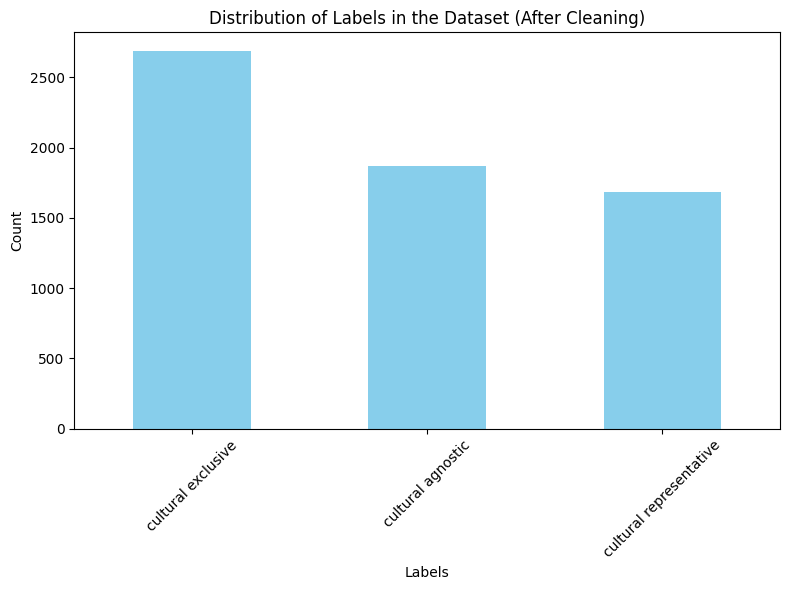

In [261]:
# 1) Count the occurrences of each label.
label_counts = df["label"].value_counts()
print("\nLabel Counts:")
print(label_counts)

# 2) Visualize the label distribution.
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels in the Dataset (After Cleaning)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 0.5.4: CLEANED DATASET INFORMATION


In [262]:
# 1) Display basic DF information.
print("=== DataFrame Info ===")
df.info()



=== DataFrame Info ===
<class 'pandas.core.frame.DataFrame'>
Index: 6238 entries, 0 to 6250
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   item         6238 non-null   object
 1   name         6238 non-null   object
 2   description  6238 non-null   object
 3   type         6238 non-null   object
 4   category     6238 non-null   object
 5   subcategory  6238 non-null   object
 6   label        6238 non-null   object
dtypes: object(7)
memory usage: 389.9+ KB


In [263]:
# 2) Display DF Staistics.
print("\n=== DataFrame Statistics===")
print(df.describe())


=== DataFrame Statistics===
                                         item                name description  \
count                                    6238                6238        6238   
unique                                   6238                6232        5659   
top     http://www.wikidata.org/entity/Q67094  central government  film genre   
freq                                        1                   2          32   

          type  category subcategory               label  
count     6238      6238        6238                6238  
unique       2        19         108                   3  
top     entity  politics  politician  cultural exclusive  
freq      3919       532          99                2686  


In [264]:
# 3) Check for duplicate rows
duplicate_mask = df.duplicated()
num_duplicates = duplicate_mask.sum()
print(f"Number of duplicate rows: {num_duplicates}")

if num_duplicates > 0:
    print("Duplicate rows:")
    print(df[duplicate_mask])

# (DUPLICATES NOT PRESENT) !

Number of duplicate rows: 0


In [265]:
# 4) Checking that we have really 19 categories, and also checking the according subcategories.
unique_categories = df["category"].unique()
unique_subcategories = df["subcategory"].unique()

print("Unique Categories:")
print(unique_categories)
print(len(unique_categories))
print("\nUnique Subcategories:")
print(unique_subcategories)
print(len(unique_subcategories))



Unique Categories:
['politics' 'food' 'architecture' 'transportation' 'sports' 'media'
 'philosophy and religion' 'literature' 'visual arts' 'fashion'
 'comics and anime' 'performing arts' 'music' 'films' 'books' 'history'
 'gestures and habits' 'biology' 'geography']
19

Unique Subcategories:
['politician' 'political party' 'government agency' 'law' 'policy'
 'government' 'food' 'drink' 'dish' 'ingredient' 'cook'
 'cooking technique' 'architectural structure' 'architectural style'
 'architect' 'construction' 'building' 'building material'
 'transport company' 'automobile manufacturer' 'transport'
 'mode of transport' 'station' 'athlete' 'sports team' 'sport'
 'sports club' 'recurring sporting event' 'sports equipment'
 'media company' 'magazine' 'television' 'production company'
 'film studio' 'streaming service' 'philosopher' 'religious leader'
 'religion' 'philosophy' 'philosophical movement' 'religious movement'
 'poetry' 'poet' 'writing style' 'literary genre' 'literary award'
 'w

In [266]:
# 5) Category-SubCategories Dictionary construction.
cat_subcat_dict = df.groupby("category")["subcategory"].unique().to_dict()

print("Categories and their subcategories:")
for cat, subcats in cat_subcat_dict.items():
    print(f"Category: {cat} -> Subcategories: {list(subcats)} (Count: {len(subcats)})")

Categories and their subcategories:
Category: architecture -> Subcategories: ['architectural structure', 'architectural style', 'architect', 'construction', 'building', 'building material'] (Count: 6)
Category: biology -> Subcategories: ['organism', 'biologist', 'animal', 'tree', 'plant', 'fish'] (Count: 6)
Category: books -> Subcategories: ['book', 'bookstore', 'non-fiction writer'] (Count: 3)
Category: comics and anime -> Subcategories: ['comics', 'comics artist', 'manga', 'animated film', 'animation technique', 'animation studio'] (Count: 6)
Category: fashion -> Subcategories: ['clothing', 'traditional costume', 'designer', 'fashion trend', 'textile', 'model'] (Count: 6)
Category: films -> Subcategories: ['film', 'film festival', 'film director', 'film producer', 'film genre'] (Count: 5)
Category: food -> Subcategories: ['food', 'drink', 'dish', 'ingredient', 'cook', 'cooking technique'] (Count: 6)
Category: geography -> Subcategories: ['geographic location', 'environment', 'mountai


Counts for each Category:
category
politics                   532
sports                     428
geography                  408
philosophy and religion    394
architecture               394
literature                 362
music                      348
food                       345
fashion                    319
visual arts                312
comics and anime           311
history                    304
media                      285
biology                    285
performing arts            275
films                      269
gestures and habits        259
transportation             217
books                      191
Name: count, dtype: int64

Counts for each Subcategory:
subcategory
politician           99
law                  95
film                 95
government agency    94
ritual               94
                     ..
environment           5
writing style         4
cooking technique     4
fashion trend         4
body language         1
Name: count, Length: 108, dtype: int64


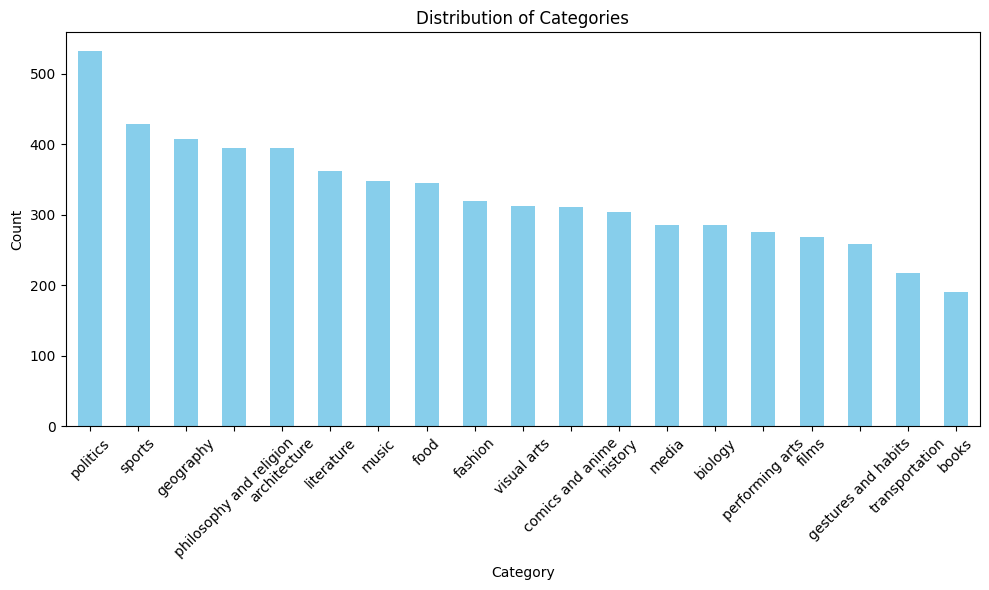

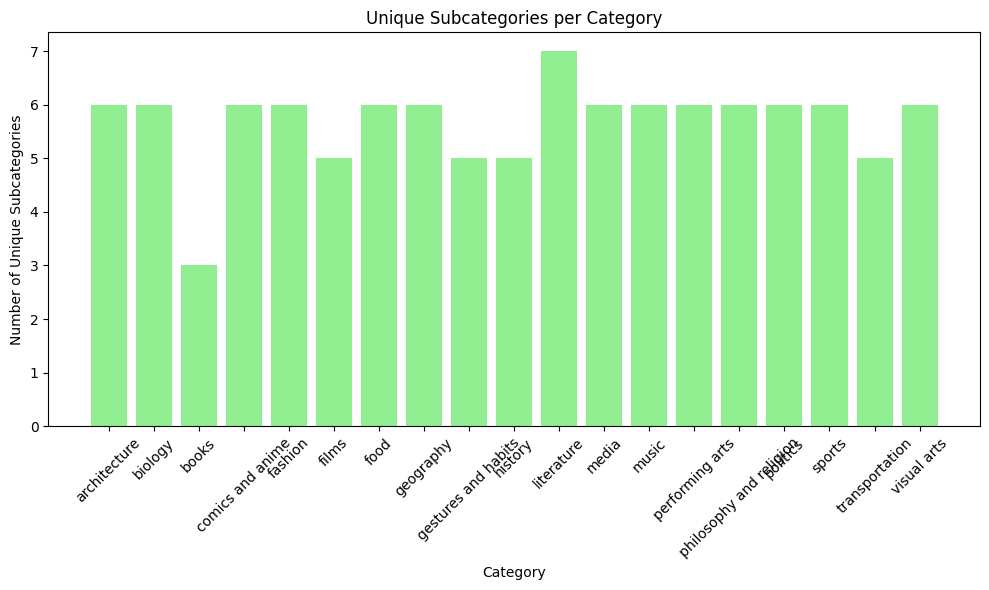

In [254]:
# 6) Additionally, print counts of entries for each category.
category_counts = df["category"].value_counts()
print("\nCounts for each Category:")
print(category_counts)

# And for each subcategory
subcategory_counts = df["subcategory"].value_counts()
print("\nCounts for each Subcategory:")
print(subcategory_counts)

# Visualize the distribution of the main categories.
category_counts = df["category"].value_counts()
plt.figure(figsize=(10,6))
category_counts.plot(kind='bar', color='skyblue')
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Distribution of Categories")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize the number of unique subcategories for each main category.
subcat_counts = {cat: len(subcats) for cat, subcats in cat_subcat_dict.items()}
plt.figure(figsize=(10,6))
plt.bar(subcat_counts.keys(), subcat_counts.values(), color='lightgreen')
plt.xlabel("Category")
plt.ylabel("Number of Unique Subcategories")
plt.title("Unique Subcategories per Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 1: GATHERING NECESSARY INFORMATION

#### 1.1: WIKIPEDIA INFORMATION EXTRACTION

In [234]:
def clean_text(text):
    """
    Util function to Parse text (summary).
    """

    text = text.replace('\n', ' ')
    return " ".join(text.split())

def get_wikipedia_data(page_url):
    '''
    Function to extract data from an English Wikipedia page.
    It retrieves:
      - Page title
      - Summary
      - Categories
      - Infobox data
      - Internal links
      - External links
      - References and citations
      - Geographical coordinates
      - List of headings (titles and subtitles)
    '''

    # 1) Title extraction.
    parsed_url = urlparse(page_url)
    title = unquote(parsed_url.path.split("/")[-1])

    # 2) Wikipedia API object for English Wikipedia.
    page = wikipediaapi.Wikipedia(
        user_agent="WikiSheaf/1.0",
        language='en'
    ).page(title)

    if not page.exists():
        return None

    # 3) Extracted data Dictionary creation.
    data = {}

    # 4) Title, Summary and Categories Inclusion in the Dictionary.
    data['title'] = page.title
    data['summary'] = clean_text(page.summary)
    data['categories'] = list(page.categories.keys())

    # 5) Infobox, internal & external links, references & citations, geo info
    #    and headings additional information.
    try:

        # Fetch parsed data from Wikipedia.
        wp_page = wptools.page(title, lang="en")
        wp_page.get_parse()
        extra = wp_page.data

        # Extract all the "additional" info.
        data["infobox"] = extra.get("infobox", None)
        data["internal_links"] = extra.get("links", None)
        data["external_links"] = extra.get("externallinks", None)
        data["references"] = extra.get("references", None)
        data["geographical_coordinates"] = extra.get("coordinates", None)
        data["headings"] = extra.get("sections", None)

    except Exception as e:
        print(f"Error fetching extra data from wptools for page '{title}':", e)
        data["infobox"] = None
        data["internal_links"] = None
        data["external_links"] = None
        data["references"] = None
        data["geographical_coordinates"] = None
        data["headings"] = None

    return data


##### 1.1.1: WIKIPEDIA INFORMATION EXTRACTION - EXAMPLE USAGE

In [235]:
print("STARTING TO EXTRACT FROM WIKIPEDIA...\n")
wikipedia_url = "https://en.wikipedia.org/wiki/Pizza"
wikipedia_data = get_wikipedia_data(wikipedia_url)

STARTING TO EXTRACT FROM WIKIPEDIA...



en.wikipedia.org (parse) Pizza
en.wikipedia.org (imageinfo) File:Pizza-3007395.jpg
Pizza (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Pizza-300...
  infobox: <dict(12)> name, image, image_size, caption, country, r...
  iwlinks: <list(6)> https://commons.wikimedia.org/wiki/Category:P...
  pageid: 24768
  parsetree: <str(77266)> <root><template><title>Short description...
  requests: <list(2)> parse, imageinfo
  title: Pizza
  wikibase: Q177
  wikidata_url: https://www.wikidata.org/wiki/Q177
  wikitext: <str(61267)> {{Short description|Italian dish with a f...
}


In [236]:
print("PRINTING DATA EXTRACTED FROM WIKIPEDIA...\n")
pprint.pprint(wikipedia_data)

PRINTING DATA EXTRACTED FROM WIKIPEDIA...

{'categories': ['Category:All Wikipedia articles written in American English',
                'Category:All articles with vague or ambiguous time',
                'Category:Articles with short description',
                'Category:CS1 Greek-language sources (el)',
                'Category:CS1 Italian-language sources (it)',
                'Category:CS1 Spanish-language sources (es)',
                'Category:CS1 Swedish-language sources (sv)',
                'Category:CS1 uses Greek-language script (el)',
                'Category:Cheese dishes',
                'Category:Commons category link is on Wikidata',
                'Category:Convenience foods',
                'Category:Flatbread dishes',
                'Category:Food combinations',
                'Category:Italian cuisine',
                'Category:Italian inventions',
                'Category:Mediterranean cuisine',
                'Category:National dishes',
         

#### 1.2: WIKIDATA INFORMATION EXTRACTION

In [237]:
def parse_wikidata_id(wikidata_url):
    '''
    Helper function to extract the Wikidata ID from a given Wikidata URL.
    '''
    return unquote(urlparse(wikidata_url).path.split("/")[-1])

def get_wikidata_data(wikidata_url):
    '''
    Function to extract the complete information from a Wikidata record.
    It retrieves:
          - Label
          - Description
          - Aliases (alternative names)
          - Instance of (P31)
          - Subclass of (P279)
          - Inception (P571)
          - Image (P18)
          - Country (P17)
          - Official website (P856)
          - Creator/Author (P170)
          - Location (P276)
          - Genre/Style (P136)
      It then extracts the English Wikipedia URL from the sitelinks and calls
      get_wikipedia_data() to fetch Wikipedia page info.
    '''
    # 1) Get the Wikidata ID.
    wikidata_id = parse_wikidata_id(wikidata_url)
    URL = f"https://www.wikidata.org/wiki/Special:EntityData/{wikidata_id}.json"

    # 2) Retrieve all the Wikidata.
    try:
        # 2.1) Fetch data from Wikidata API.
        response = requests.get(URL)
        data = response.json()
        entity = data.get("entities", {}).get(wikidata_id, {})
        wikidata_info = {}
        wikidata_info["id"] = wikidata_id

        # 2.2) Retrieve basic labels, descriptions.
        wikidata_info["label"] = entity.get("labels", {}).get("en", {}).get("value", None)
        wikidata_info["description"] = entity.get("descriptions", {}).get("en", {}).get("value", None)

        # 2.3) Retrieve aliases (alternative names) in English.
        if "aliases" in entity and "en" in entity["aliases"]:
            wikidata_info["aliases"] = [alias.get("value") for alias in entity["aliases"]["en"]]
        else:
            wikidata_info["aliases"] = None

        # 2.4) Extract claims (properties (each one may include multiple values)).
        claims = entity.get("claims", {})

        # 2.4.1) "Instance of" (P31).
        if "P31" in claims:
            wikidata_info["instance_of"] = [
                claim["mainsnak"]["datavalue"]["value"]["id"]
                for claim in claims["P31"]
                if "mainsnak" in claim and "datavalue" in claim["mainsnak"]
            ]
        else:
            wikidata_info["instance_of"] = None

        # 2.4.2) "Subclass of" (P279).
        if "P279" in claims:
            wikidata_info["subclass_of"] = [
                claim["mainsnak"]["datavalue"]["value"]["id"]
                for claim in claims["P279"]
                if "mainsnak" in claim and "datavalue" in claim["mainsnak"]
            ]
        else:
            wikidata_info["subclass_of"] = None

        # 2.4.3) "Inception" (P571).
        if "P571" in claims:
            wikidata_info["inception"] = [
                claim["mainsnak"]["datavalue"]["value"]["time"]
                for claim in claims["P571"]
                if "mainsnak" in claim and "datavalue" in claim["mainsnak"]
            ]
        else:
            wikidata_info["inception"] = None

        # 2.4.4) "Image" (P18).
        if "P18" in claims:
            wikidata_info["image"] = [
                claim["mainsnak"]["datavalue"]["value"]
                for claim in claims["P18"]
                if "mainsnak" in claim and "datavalue" in claim["mainsnak"]
            ]
        else:
            wikidata_info["image"] = None

        # 2.4.5) "Country" (P17).
        if "P17" in claims:
            wikidata_info["country"] = [
                claim["mainsnak"]["datavalue"]["value"]["id"]
                for claim in claims["P17"]
                if "mainsnak" in claim and "datavalue" in claim["mainsnak"]
            ]
        else:
            wikidata_info["country"] = None

        # 2.4.6) "Official website" (P856).
        if "P856" in claims:
            wikidata_info["official_website"] = [
                claim["mainsnak"]["datavalue"]["value"]
                for claim in claims["P856"]
                if "mainsnak" in claim and "datavalue" in claim["mainsnak"]
            ]
        else:
            wikidata_info["official_website"] = None

        # 2.4.7) "Creator/Author" (P170). (for cultural items like art or literature).
        if "P170" in claims:
            wikidata_info["creator"] = [
                claim["mainsnak"]["datavalue"]["value"]["id"]
                for claim in claims["P170"]
                if "mainsnak" in claim and "datavalue" in claim["mainsnak"]
            ]
        else:
            wikidata_info["creator"] = None

        # 2.4.8) "Location" (P276).
        if "P276" in claims:
            wikidata_info["location"] = [
                claim["mainsnak"]["datavalue"]["value"]["id"]
                for claim in claims["P276"]
                if "mainsnak" in claim and "datavalue" in claim["mainsnak"]
            ]
        else:
            wikidata_info["location"] = None

        # 2.4.9) "Genre/Style" (P136).
        if "P136" in claims:
            wikidata_info["genre"] = [
                claim["mainsnak"]["datavalue"]["value"]["id"]
                for claim in claims["P136"]
                if "mainsnak" in claim and "datavalue" in claim["mainsnak"]
            ]
        else:
            wikidata_info["genre"] = None

        # 2.5) Extract English Wikipedia URL and call the get_wikipedia_data() function.
        if "sitelinks" in entity and "enwiki" in entity["sitelinks"]:
            wikipedia_url = entity["sitelinks"]["enwiki"].get("url", None)
        else:
            wikipedia_url = None
        wikidata_info["wikipedia_url"] = wikipedia_url

        if wikipedia_url:
            wiki_data = get_wikipedia_data(wikipedia_url)
        else:
            wiki_data = None
        wikidata_info["wikipedia_data"] = wiki_data

        return wikidata_info

    except Exception as e:
        print(f"Error fetching Wikidata data for {wikidata_url}: {e}")
        return None

##### 1.2.1: WIKIDATA INFORMATION EXTRACTION - EXAMPLE USAGE

In [238]:
wikidata_url = "https://www.wikidata.org/wiki/Q177" # (Pizza)
wikidata_record = get_wikidata_data(wikidata_url)

en.wikipedia.org (parse) Pizza
en.wikipedia.org (imageinfo) File:Pizza-3007395.jpg
Pizza (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Pizza-300...
  infobox: <dict(12)> name, image, image_size, caption, country, r...
  iwlinks: <list(6)> https://commons.wikimedia.org/wiki/Category:P...
  pageid: 24768
  parsetree: <str(77266)> <root><template><title>Short description...
  requests: <list(2)> parse, imageinfo
  title: Pizza
  wikibase: Q177
  wikidata_url: https://www.wikidata.org/wiki/Q177
  wikitext: <str(61267)> {{Short description|Italian dish with a f...
}


In [239]:
pprint.pprint(wikidata_record)

{'aliases': ['pie', 'pizza pie'],
 'country': None,
 'creator': None,
 'description': 'Italian universal popular dish with a flat dough-based base '
                'and toppings',
 'genre': None,
 'id': 'Q177',
 'image': ['Eq it-na pizza-margherita sep2005 sml.jpg', 'Pizza-3007395.jpg'],
 'inception': None,
 'instance_of': ['Q19861951'],
 'label': 'pizza',
 'location': None,
 'official_website': None,
 'subclass_of': ['Q13030962', 'Q1408229', 'Q749316', 'Q2251745', 'Q26996677'],
 'wikipedia_data': {'categories': ['Category:All Wikipedia articles written in '
                                   'American English',
                                   'Category:All articles with vague or '
                                   'ambiguous time',
                                   'Category:Articles with short description',
                                   'Category:CS1 Greek-language sources (el)',
                                   'Category:CS1 Italian-language sources (it)',
             

In [240]:
# Just checking whether the Summary has been parsed correctly.
print(wikidata_record["wikipedia_data"]["summary"] + "\n")
print(str(type(wikidata_record["wikipedia_data"]["summary"])) + "\n")
print("\n" in wikidata_record["wikipedia_data"]["summary"] )


Pizza is an Italian, specifically Neapolitan, dish typically consisting of a flat base of leavened wheat-based dough topped with tomato, cheese, and other ingredients, baked at a high temperature, traditionally in a wood-fired oven. The term pizza was first recorded in 997 AD, in a Latin manuscript from the southern Italian town of Gaeta, in Lazio, on the border with Campania. Raffaele Esposito is often credited for creating the modern pizza in Naples. In 2009, Neapolitan pizza was registered with the European Union as a traditional speciality guaranteed (TSG) dish. In 2017, the art of making Neapolitan pizza was included on UNESCO's list of intangible cultural heritage. Pizza and its variants are among the most popular foods in the world. Pizza is sold at a variety of restaurants, including pizzerias (pizza specialty restaurants), Mediterranean restaurants, via delivery, and as street food. In Italy, pizza served in a restaurant is presented unsliced, and is eaten with the use of a kn

### 2: BUILDING THE GRAPHS
--------------------------
**HETEROUGENEOUS GRAPHS**

For this task, we will build a set of **Heterogeneous Graphs**. This is a graph in which **nodes and/or edges belong to different types**. In other words, it is a **multi-relational graph** where each node may have its own feature space and each edge represents a specific type of relationship.

In our implementation, the **main entity** (for example, a food item like "Pizza") is represented as a **primary node** (of type "item"). **Additional nodes** are created for **various attributes** (e.g., categories, instance_of, subclass_of, creator, location, genre) using the enriched data from Wikidata and Wikipedia. Each attribute node is connected to the main item node by an edge that denotes the nature of the relationship (e.g., "has_category" for categories).

--------------------------
**CONTEXTUAL EMBEDDINGS**

To generate meaningful **feature vectors**, we employ a **Sentence Transformer** (using the ***all-mpnet-base-v2 model***) to compute Contextual Embeddings. We enhance the representation of the main node by unifying the label and the Wikipedia summary into one text. This is then encoded into a dense vector that captures fine semantic nuances. The attribute nodes are similarly embedded using their respective textual information.

*WHY SENTENCE TRASNFORMER: all-mpnet-base-v2 model*

We choose **all-mpnet-base-v2 model** because it strikes an excellent balance between efficiency and the quality of contextual embeddings. Indeed:

- **BERT** adopts masked language modeling (MLM) for pre-training and is one of the most successful pre-training models. However BERT neglects dependency among predicted tokens. *BERT* and *RoBERTa* at their time set a new state-of-the-art performance (particularly on sentence-pair regression tasks like semantic textual similarity (STS)), but they however require that both sentences are fed into the network, causing a **massive computational overhead**. The construction of BERT makes it unsuitable for semantic similarity search. **Sentence-BERT (SBERT)** is a modification of the pretrained BERT network that use siamese and triplet network structures to derive semantically meaningful sentence embeddings that can be compared using cosine-similarity. This reduces the effort for finding the most similar pair from 65 hours with BERT / RoBERTa to about 5 seconds with SBERT, while maintaining the accuracy from BERT.
- **XLNet** introduces permuted language modeling (PLM) for pre-training to address this problem. However, XLNet does not leverage the full position information of a sentence and thus suffers from position discrepancy between pre-training and fine-tuning.
- **MPNet** inherits the advantages of BERT and XLNet and avoids their limitations. MPNet leverages the dependency among predicted tokens through permuted language modeling (vs. MLM in BERT), and takes auxiliary position information as input to make the model see a full sentence and thus reducing the position discrepancy (vs. PLM in XLNet). Also as concerns avg performances in terms of speed, we also have that this is fast w.r.t. the others.

For more info about model performances: https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

***(REFERENCES)***
- *BERT*: https://arxiv.org/abs/1810.04805
- *RoBERTa*: https://arxiv.org/abs/1907.11692
- *XLNet*: https://arxiv.org/abs/1906.08237
- *Sentence-BERT*: https://arxiv.org/abs/1908.10084
- *MPNet*: https://arxiv.org/abs/2004.09297



--------------------------
**EDGES WEIGHTING: COSINE SIMILARITY**

**Edges** between the main node and each attribute node are **weighted** by computing the **Cosine Similarity** between their **embeddings**. We decide to apply this with the aim to have them to be **Semantic Similarity Scores** that help to reflect the **main entity & its attributes relationship strength**.


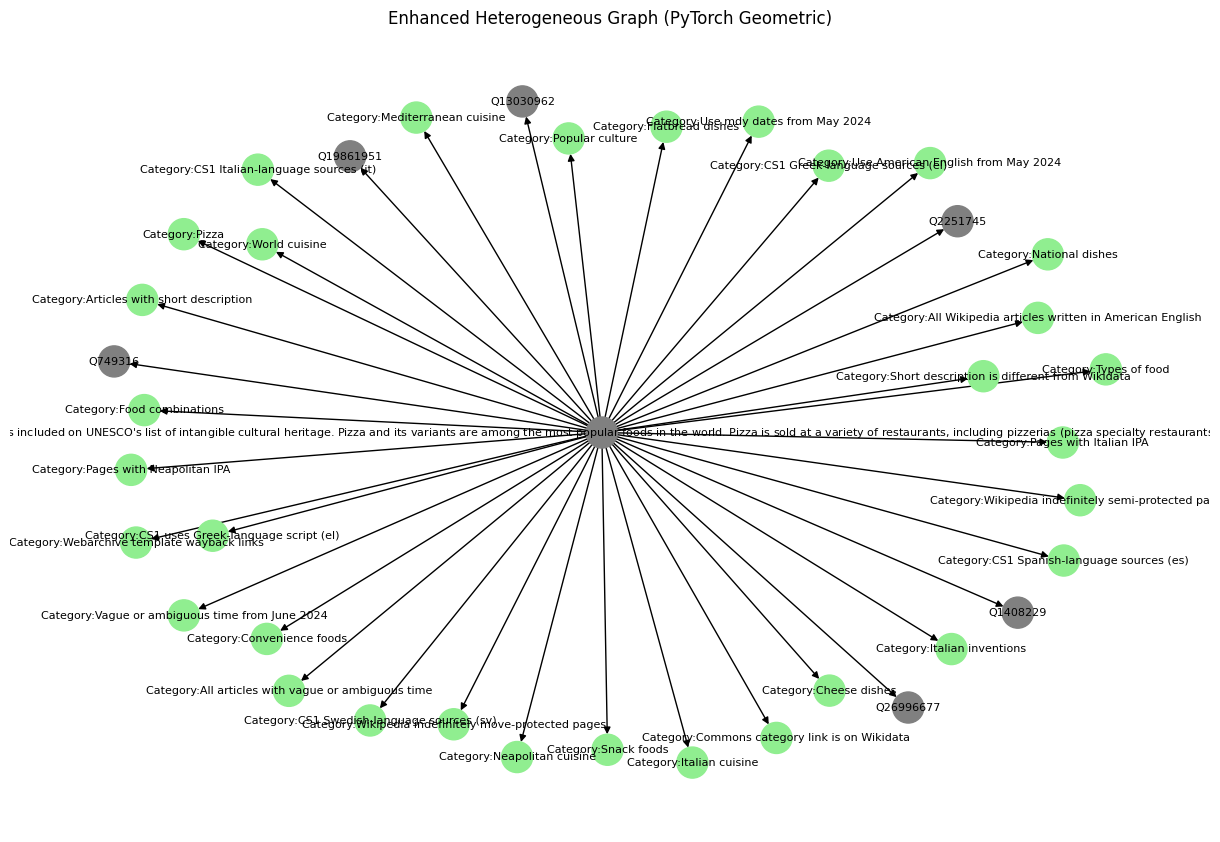

In [241]:
def build_h_graph(wikidata_info):
    """
    Build an Heterogeneous Graph from the gathered wikidata information.

    Node Types:
      - "item": the main entity.
      - "category", "instance", "subclass", "creator", "location", "genre": attribute nodes.

    Workflow we follow:
    - For each node, we compute a contextual embedding from its text.
    - For the main node, we compute the embedding from a unified string that concatenates
      the label and the Wikipedia summary.
    - For edges, we compute semantic similarity (cosine similarity) between the main item's embedding
      and the attribute node embedding as the edge weight.

    At the end we will return h_graph (a HeteroData object (representing the graph)).
    """


    def add_attr_nodes(attr_list, node_type, edge_type):
        """
        Helper function to add attribute nodes and edges to the graph.
        """

        # If the attribute list is (None or empty), create an empty node set.
        if not attr_list:
            h_graph[node_type].x = torch.empty((0, main_embedding.size(1)), dtype=torch.float)
            h_graph[node_type].label = []
            return

        # A) Compute Embeddings for each attribute.
        embeddings = model.encode(attr_list)
        embeddings = torch.tensor(embeddings, dtype=torch.float)
        h_graph[node_type].x = embeddings
        h_graph[node_type].label = attr_list

        # B) Create edge index (let's connect main item node to each attribute node).
        num_nodes = embeddings.size(0)
        edge_index = torch.stack([torch.zeros(num_nodes, dtype=torch.long),
                                  torch.arange(num_nodes, dtype=torch.long)], dim=0)

        # C) Compute Cosine Similarity between main_embedding and each attribute embedding.
        sim_scores = F.cosine_similarity(main_embedding.squeeze(0).unsqueeze(0).expand(num_nodes, -1), embeddings, dim=1)

        # D) Reshape CosSimilarity Scores as edge attributes.
        edge_attr = sim_scores.unsqueeze(1)  # shape [num_nodes, 1]
        h_graph[("item", edge_type, node_type)].edge_index = edge_index
        h_graph[("item", edge_type, node_type)].edge_attr = edge_attr


    # 1) Initialize an (empty) heterogeneous graph container.
    h_graph = HeteroData()

    # 2) Add the main item node.
    main_id = wikidata_info["id"]

    # 3) Retrieve label+summary and compute Contextual Embedding.
    main_label = wikidata_info.get("label", main_id)
    wiki_data = wikidata_info.get("wikipedia_data", {})
    main_summary = wiki_data.get("summary", "")
    unified_text = f"{main_label}: {main_summary}" if main_summary else main_label

    model = SentenceTransformer('all-mpnet-base-v2')
    main_embedding = model.encode(unified_text)
    main_embedding = torch.tensor(main_embedding, dtype=torch.float).unsqueeze(0)  # shape [1, emb_dim]
    h_graph["item"].x = main_embedding
    h_graph["item"].label = [unified_text]



    # For categories, use wikipedia_data categories.
    categories = wiki_data.get("categories", [])
    add_attr_nodes(categories, "category", "has_category")

    # For instance_of:
    add_attr_nodes(wikidata_info.get("instance_of", []), "instance", "instance_of")

    # For subclass_of:
    add_attr_nodes(wikidata_info.get("subclass_of", []), "subclass", "subclass_of")

    # For creator:
    add_attr_nodes(wikidata_info.get("creator", []), "creator", "creator")

    # For location:
    add_attr_nodes(wikidata_info.get("location", []), "location", "location")

    # For genre:
    add_attr_nodes(wikidata_info.get("genre", []), "genre", "genre")

    return h_graph

# ========================
# Visualization: Convert to a NetworkX graph for visualization.
# ========================
def visualize_hetero_graph(h_graph):
    """
    Visualize the heterogeneous graph by converting it to a homogeneous NetworkX graph.
    For simplicity, nodes are colored based on their type.
    """
    G = to_networkx(h_graph, node_attrs=['label'])
    pos = nx.spring_layout(G, seed=42)

    # Define a simple color mapping based on node types.
    color_map = []
    for node in G.nodes():
        label = G.nodes[node].get('label', '')
        if isinstance(label, list) and len(label) > 0:
            label = label[0]
        if node in h_graph["item"].label:
            color_map.append("lightblue")
        elif any(prefix in label for prefix in ["Category:", "cat:"]):
            color_map.append("lightgreen")
        else:
            color_map.append("gray")

    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'label'),
            node_color=color_map, node_size=500, font_size=8)
    plt.title("Enhanced Heterogeneous Graph (PyTorch Geometric)")
    plt.show()

# ========================
# Example Usage
# ========================
if __name__ == "__main__":
    # Assume get_wikidata_data() is defined and returns enriched h_graph.
    # For example:
    # wikidata_url = "https://www.wikidata.org/wiki/Q177"
    # wikidata_info = get_wikidata_data(wikidata_url)
    wikidata_info = wikidata_record  # using our sample data

    # Build the enhanced heterogeneous graph.
    hetero_graph = build_h_graph(wikidata_info)

    # Visualize the graph.
    visualize_hetero_graph(hetero_graph)


### 3: HETEROPHILY INDEX

### 4: SHEAF NEURAL NETWORK